<a href="https://colab.research.google.com/github/lukaszplust/Machine-Learning/blob/main/Lab_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

decision_tree

In [3]:
from collections import defaultdict
import numpy as np

class DecisionTree:
    def __init__(self, params):
        self.root_node = Node()
        self.params = defaultdict(lambda: None, params)


    def train(self, X, y):
        self.root_node.train(X, y, self.params)

    def evaluate(self, X, y):
        predicted = self.predict(X)
        predicted = [round(p) for p in predicted]
        print(f"Accuracy: {round(np.mean(predicted==y),2)}")

    def predict(self, X):
        prediction = []
        for x in X:
            prediction.append(self.root_node.predict(x))
        return prediction

load_data.py

In [4]:
import numpy as np
import pandas as pd
def generate_data():
    TRAIN_SAMPLES = 100
    TEST_SAMPLES = 20
    FEATURE_DIM = 5

    X_train = np.random.rand(TRAIN_SAMPLES, FEATURE_DIM)
    y_train = np.random.binomial(1, 0.5, TRAIN_SAMPLES)
    X_test = np.random.rand(TEST_SAMPLES, FEATURE_DIM)
    y_test = np.random.binomial(1, 0.5, TEST_SAMPLES)
    return (X_train, y_train), (X_test, y_test)


def load_titanic():
    data = pd.read_csv("titanic.csv")
    data = data[["Pclass", "Fare", "Parch", "SibSp", "Age", "Sex", "Survived"]]
    data = data.dropna().reset_index(drop=True)
    data["Sex"] = [1 if sex == "female" else 0 for sex in data["Sex"]]
    test_idx = np.random.choice(range(data.shape[0]), round(0.2*data.shape[0]), replace=False)
    data_test = data.iloc[test_idx, :]
    data_train = data.drop(test_idx, axis=0)
    X_train = data_train.drop("Survived", axis=1).to_numpy()
    y_train = data_train["Survived"].to_numpy()
    X_test = data_test.drop("Survived", axis=1).to_numpy()
    y_test = data_test["Survived"].to_numpy()
    return (X_train, y_train), (X_test, y_test)

node.py

In [14]:
import copy

import numpy as np


class Node:
    def __init__(self):
        self.left_child = None
        self.right_child = None
        self.feature_idx = None
        self.feature_value = None
        self.node_prediction = None

    def gini_best_score(self, y, possible_splits):
        best_gain = -np.inf
        best_idx = 0

        # TODO find position of best data split --> DONE !!

        for idx in possible_splits:

          left_y = y[:idx]
          right_y = y[idx:]

          # lewe dziecko (info z insrukcji)
          left_positive = np.sum(left_y == 1)
          left_negative = np.sum(left_y == 0)

          # prawe dziecko (info z insrukcji)
          right_positive = np.sum(right_y == 1)
          right_negative = np.sum(right_y == 0)


          right = right_positive + right_negative
          left = left_positive + left_negative



          left_gini = 1 - ((left_positive / (left_negative + left_positive)) ** 2 + (left_negative / (left_negative + left_positive)) ** 2) # (4.3)
          right_gini = 1 - ((right_positive / (right_negative + right_positive)) ** 2 + (right_negative / (right_negative + right_positive)) ** 2) # (4.4)

          # wyższy Gini gain oznacza czystszy (lepszy) podział
          gini_gain = 1 - ((left / (left + right)) * left_gini + ((right / (left + right)) * right_gini)) # (4.2)

          if gini_gain > best_gain:
            best_gain = gini_gain
            best_idx = idx

        return best_idx, best_gain

    def split_data(self, X, y, idx, val):
        left_mask = X[:, idx] < val
        return (X[left_mask], y[left_mask]), (X[~left_mask], y[~left_mask])

    def find_possible_splits(self, data):
        possible_split_points = []
        for idx in range(data.shape[0] - 1):
            if data[idx] != data[idx + 1]:
                possible_split_points.append(idx)
        return possible_split_points

    def find_best_split(self, X, y, feature_subset):
        best_gain = -np.inf
        best_split = None

        # TODO implement feature selection ---> READY !!!


        # X.shape[1] zwraca liczbę kolumn w macierzy X, co odpowiada liczbie cech
        # np.arange -> tworze tablice indeksow

        feature_indices = np.arange(X.shape[1])

        #sprawdzam czy feature_subset nie jest wartoscia None

        # Zmienna feature_subset określa liczbę losowo wybranych cech,
        # które będą brane pod uwagę podczas poszukiwania najlepszego podziału danych

        if feature_subset is not None:

          # miesza (losowo przestawia kolejność) indeksy cech,
          # które są przechowywane w tablicy feature_indices.
          # Jest to wykonane w celu losowego wyboru cech do dalszej analizy

          # np.random.shuffle miesza (losowo przestawia kolejność indeksow) indeksy cech,
          # które są przechowywane w tablicy feature_indices.

          #Jest to wykonane w celu losowego wyboru cech do dalszej analizy.
          np.random.shuffle(feature_indices)

          # wybrane zostana tylko feature_subset pierwszych indeksów z listy feature_indices

          # oznacza to, że będe używać tylko tych cech, które są wskazane przez te wybrane indeksy,
          # a reszta zostanie pominięta

          feature_indices = feature_indices[:feature_subset]

        for d in range(X.shape[1]):
            order = np.argsort(X[:, d])
            y_sorted = y[order]
            possible_splits = self.find_possible_splits(X[order, d])
            idx, value = self.gini_best_score(y_sorted, possible_splits)
            if value > best_gain:
                best_gain = value
                best_split = (d, [idx, idx + 1])

        if best_split is None:
            return None, None

        best_value = np.mean(X[best_split[1], best_split[0]])

        return best_split[0], best_value

    def predict(self, x):
        if self.feature_idx is None:
            return self.node_prediction
        if x[self.feature_idx] < self.feature_value:
            return self.left_child.predict(x)
        else:
            return self.right_child.predict(x)

    def train(self, X, y, params):

        self.node_prediction = np.mean(y)
        if X.shape[0] == 1 or self.node_prediction == 0 or self.node_prediction == 1:
            return True

        self.feature_idx, self.feature_value = self.find_best_split(X, y, params["feature_subset"])
        if self.feature_idx is None:
            return True

        (X_left, y_left), (X_right, y_right) = self.split_data(X, y, self.feature_idx, self.feature_value)

        if X_left.shape[0] == 0 or X_right.shape[0] == 0:
            self.feature_idx = None
            return True

        # max tree depth
        if params["depth"] is not None:
            params["depth"] -= 1
        if params["depth"] == 0:
            self.feature_idx = None
            return True

        # create new nodes
        self.left_child, self.right_child = Node(), Node()
        self.left_child.train(X_left, y_left, copy.deepcopy(params))
        self.right_child.train(X_right, y_right, copy.deepcopy(params))


random_fores.py

In [15]:
from collections import defaultdict
import numpy as np

class RandomForest:
    def __init__(self, params):

        self.forest = []
        self.params = defaultdict(lambda: None, params)


    def train(self, X, y):
        # przechodze przez kazde drzewo w lesie
        for _ in range(self.params["ntrees"]):

            # tworze losowy zestaw danych treningowych za pomocą baggingu
            X_bagging, y_bagging = self.bagging(X,y)

            # tworzenie nowego drzewa decyzyjnego i trenowanie go na losowym zestawie danych
            tree = DecisionTree(self.params)
            tree.train(X_bagging, y_bagging)
            # dodanie nowego drzewa do lasu
            self.forest.append(tree)

    def evaluate(self, X, y):

        # Prognozowanie etykiet za pomocą lasu
        predicted = self.predict(X)

        # Zaokrąglenie prognozowanych wartości do najbliższej liczby całkowitej
        predicted = [round(p) for p in predicted]
        print(f"Accuracy: {round(np.mean(predicted==y),2)}")

    def predict(self, X):
        tree_predictions = []
        for tree in self.forest:
            tree_predictions.append(tree.predict(X))
        forest_predictions = list(map(lambda x: sum(x)/len(x), zip(*tree_predictions)))
        return forest_predictions

    def bagging(self, X, y):
        #X_selected, y_selected = None, None
        # TODO implement bagging ---> DONE

        # np.random.randint(start, stop, size)
        # losuje liczby całkowite z zakresu od 0 do len(X) z powtorzeniami
        indices = np.random.randint(0, len(X), len(X))

        # X_selected to losowo wybrany podzbiór danych treningowych z oryginalnego zestawu X
        X_selected = X[indices]

        # y_selected to odpowiadające im etykiety (czyli wektory wyników) wybrane z oryginalnego zestawu y
        y_selected = y[indices]
        return X_selected, y_selected

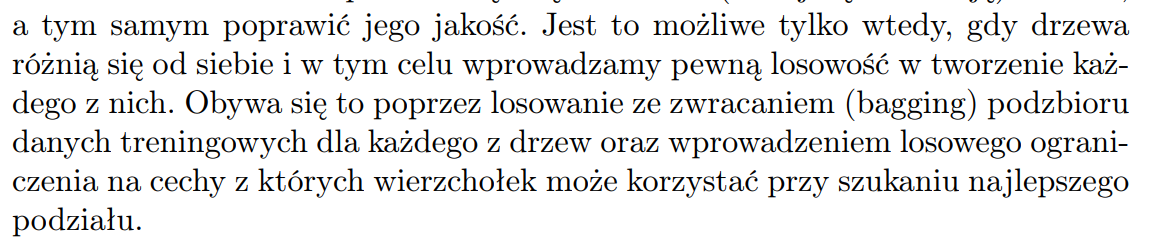

In [19]:
import numpy as np

def main():
    np.random.seed(123)

    train_data, test_data = load_titanic()

    dt = DecisionTree({"depth": 14})

    dt.train(*train_data)

    print("Results for Decision Tree: ")
    #najpierw dla danych treningowych
    dt.evaluate(*train_data)
    # pozniej dla testowych
    dt.evaluate(*test_data)

    print("Results for Random Forest: ")
    rf = RandomForest({"ntrees": 10, "feature_subset": 2, "depth": 14})

    rf.train(*train_data)
    #najpierw dla danych treningowych
    rf.evaluate(*train_data)
    # pozniej dla testowych
    rf.evaluate(*test_data)

if __name__=="__main__":
    main()

<ipython-input-14-6314f90ad01a>:38: RuntimeWarning: invalid value encountered in scalar divide
  left_gini = 1 - ((left_positive / (left_negative + left_positive)) ** 2 + (left_negative / (left_negative + left_positive)) ** 2) # (4.3)


Results for Decision Tree: 
Accuracy: 0.86
Accuracy: 0.78
Results for Random Forest: 
Accuracy: 0.89
Accuracy: 0.83
